In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nolds
from nolitsa import lyapunov,dimension,delay,noise,data

In [2]:
%matplotlib inline
#We define a function useful to find local minimizers
def localmin(x):
    """Return all local minima from the given data set.
    Returns all local minima from the given data set.  Note that even
    "kinky" minima (which are probably not real minima) will be
    returned.
    Parameters
    ----------
    x : array
        1D scalar data set.
    Returns
    -------
    i : array
        Array containing location of all local minima.
    """
    return (np.diff(np.sign(np.diff(x))) > 0).nonzero()[0] + 1

In [3]:
#https://ourworldindata.org/coronavirus-source-data
data = pd.read_csv(r'C:\Users\javie\Covid19\datas\owid-covid-data-01-03.csv')
df =pd.DataFrame(data)
#Belgica
Blegiumdata=df.loc[df['location']=='Belgium']
Belgiumts=np.array(Blegiumdata.new_cases_per_million).astype(float)/10

#Noruega
Norwaydata=df.loc[df['location']=='Norway']
Norwayts=np.array(Norwaydata.new_cases_per_million).astype(float)[1:]/10
# Norwayts=Norwayts[3:]

#Estados Unidos
USdata=df.loc[df['location']=='United States']
USts=np.array(USdata.new_cases_per_million).astype(float)[1:]/10
# USts=USts[1:]

#Chile
Chiledata=df.loc[df['location']=='Chile']
Chilets=np.array(Chiledata.new_cases_per_million).astype(float)/10

#Dinamarca
Denmarkdata=df.loc[df['location']=='Denmark']
Denmarkts=np.array(Denmarkdata.new_cases_per_million).astype(float)[25:]/10
# [11:]
# Denmarkts=Denmarkts[14:]

#Canada
Canadadata=df.loc[df['location']=='Canada']
Canadats=np.array(Canadadata.new_cases_per_million).astype(float)/10

#Republica Checa
CzechRdata=df.loc[df['location']=='Czech Republic']
CzechRts=np.array(CzechRdata.new_cases_per_million).astype(float)/10

#Nueva Zelanda
NZdata=df.loc[df['location']=='New Zealand']
NZts=np.array(NZdata.new_cases_per_million).astype(float)/10

#Alemania
Alemaniadata=df.loc[df['location']=='Germany']
Alemaniats=np.array(Alemaniadata.new_cases_per_million).astype(float)[3:]/10

#Italia
Italydata=df.loc[df['location']=='Italy']
Italiats=np.array(Italydata.new_cases_per_million).astype(float)/10

#Solo no se encuentra republica checa, quizas con otro nombre.
#Quitamos NZ también.

#AGREGAMOS NUEVA ZELANDA, JAPON, COREA DEL SUR, AUSTRALIA.

Japandata=df.loc[df['location']=='Japan']
Japants=np.array(Japandata.new_cases_per_million).astype(float)[1:]/10
# [1:]

SKdata=df.loc[df['location']=='South Korea']
SKts=np.array(SKdata.new_cases_per_million).astype(float)[2:]/10
# [2:]

Australiadata=df.loc[df['location']=='Australia']
Australiats=np.array(Australiadata.new_cases_per_million).astype(float)/10

In [4]:
#We save the dates
Fechas=df['date'].astype(str).values.tolist()

In [5]:
Time_series=[Belgiumts,Norwayts,
             USts,Chilets,Denmarkts, 
             Alemaniats, Italiats,
             Japants, SKts, Australiats, NZts]
Paises=['Belgica', 'Noruega', 'Estados Unidos', 'Chile', 'Dinamarca', 'Alemania', 'Italia', 'Japon', 'Corea del Sur',
       'Australia','Nueva Zelanda']

In [6]:
N=11
L=250
TS=[]
for serie in Time_series:
    TS.append(serie[:L])

Minima of delayed mutual information = [ 6 17 21 28 33 36 44 48 56 58 65 69 71 74 81 83 85 91 93 97]
Autocorrelation time = 12


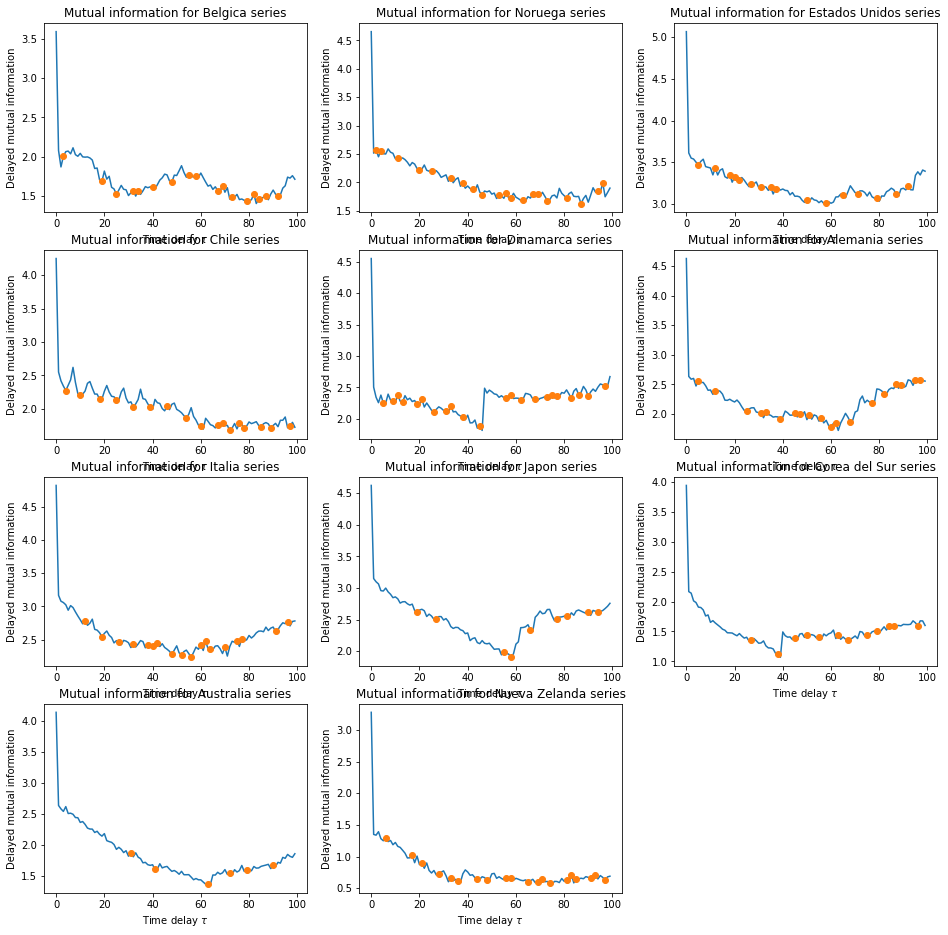

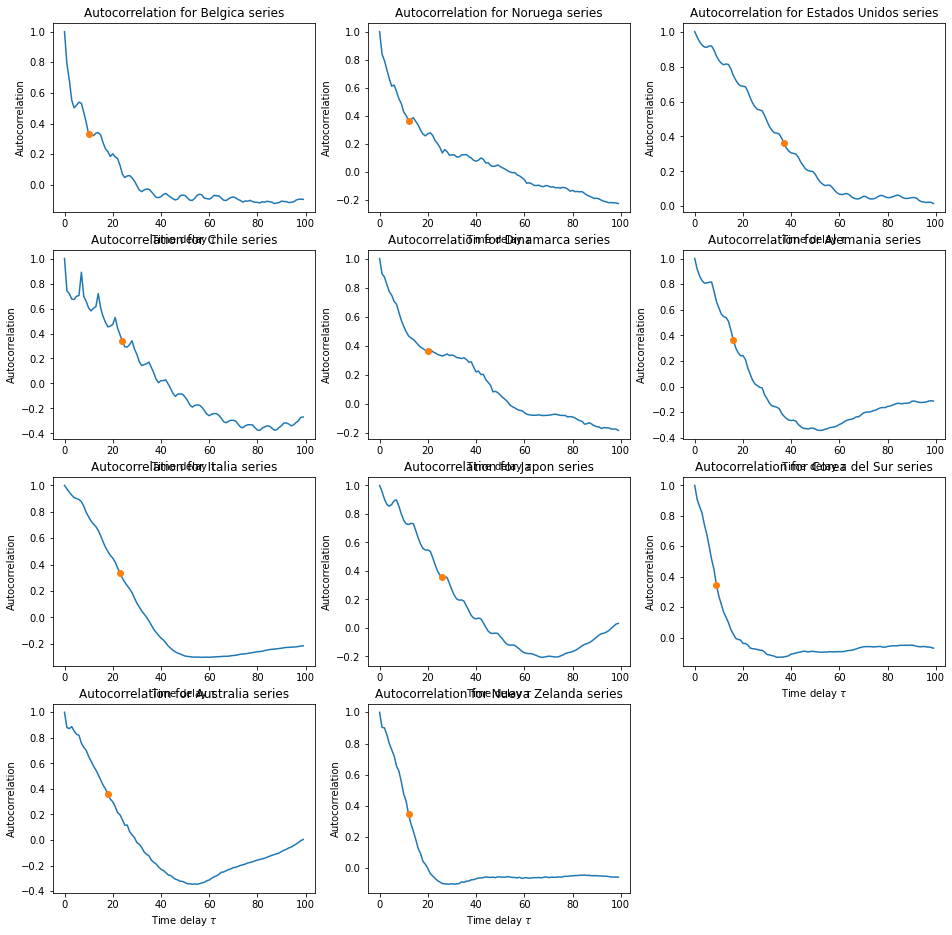

In [7]:
#Mutual information.
# Compute autocorrelation and delayed mutual information.
lag = np.arange(100)
i_delay=np.zeros(N)
r_delay=np.zeros(N)
plt.figure(1,figsize=(16,16))
Minimals=np.zeros(N)
for j in range(N):
    x=TS[j]
    i = delay.dmi(x, maxtau=100)
    i_delay = localmin(noise.sma(i, hwin=1)) + 1
    plt.subplot(4,3,j+1)
    plt.title(r'Mutual information for ' + str(Paises[j]) +' series')
    plt.ylabel(r'Delayed mutual information')
    plt.xlabel(r'Time delay $\tau$')
    plt.plot(lag, i, i_delay, i[i_delay], 'o')
    Minimals[j]=i_delay[0]
print(r'Minima of delayed mutual information = %s' % i_delay)


#Autocorrelation
Autocorrnumber=np.zeros(N)
plt.figure(2,figsize=(16,16))
for j in range(N):
    x=TS[j]
    r = delay.acorr(x, maxtau=100)
    r_delay = np.argmax(r < 1.0 / np.e)
    
    plt.subplot(4,3,j+1)
    plt.title(r'Autocorrelation for ' + str(Paises[j]) +' series')
    plt.xlabel(r'Time delay $\tau$')
    plt.ylabel(r'Autocorrelation')
    plt.plot(lag, r, r_delay, r[r_delay], 'o')
    Autocorrnumber[j]=r_delay
print(r'Autocorrelation time = %d' % r_delay)

In [8]:
#Define Tau and Theilers window
Tau=Minimals
Theiler=Autocorrnumber*3

In [9]:
Tau[7]=Tau[8]=Tau[9]=5
Tau

array([ 3.,  2.,  5.,  4.,  5.,  5., 12., 19., 27., 31.,  6.])

In [11]:
#We use the same embedding dimensions obtained from the full series
Embdim=[5,6,6,6,7,7,6,6,8,6,7]

In [12]:
def Lyapunov(X,tauu,d,theiler,maxnumb=None):
    MLEs_nolitsa=np.zeros(1)
    #Compute the average divergence for each time up to maxt
    LEs=lyapunov.mle_embed(X, dim=[int(d)], tau=int(tauu), window=int(theiler), maxt=100, maxnum=maxnumb)[0]
    #sma=noise.sma(LEs[:40], hwin=0)
    sma=LEs[:40]
    p = np.polyfit(np.arange(len(sma)), sma,deg=1)
    xaxis = np.arange(len(sma))
    yaxis = p[1] + p[0] * xaxis
    #Compute the maximum lyapunov exponent as the slope
    MLEs_nolitsa[0]=p[0]
    return MLEs_nolitsa[0]*365

In [13]:
#Construyamos la lista de los diez vectores de longitudes diferentes, que sean compatibles con las fechas hasta la última 
#disponible.
Lyapse=[]
for k in range(N):
    Lyapse.append(np.zeros(len(Time_series[k])-250))


In [14]:
#We correct some theiler windows that may be bigger than they should be
Theiler[2]=Theiler[3]=60

In [15]:
#We compute the evolution of the corresponding Lyapunov exponents
for j in range(0,3):
    for t in range(len(Lyapse[j])):
        Y=Time_series[j][t:250+t]
        Lyapse[j][t]=Lyapunov(Y,Tau[j],Embdim[j],Theiler[j],220)
    print('listo el '+str(j))

listo el 0
listo el 1
listo el 2


In [16]:
Tau[7]=Tau[8]=Tau[9]=5
for j in range(3,6):
    for t in range(len(Lyapse[j])):
        Y=Time_series[j][t:250+t]
        Lyapse[j][t]=Lyapunov(Y,Tau[j],Embdim[j],Theiler[j],200)
    print('listo el '+str(j))

listo el 3
listo el 4
listo el 5


In [17]:
for j in range(6,9):
    for t in range(len(Lyapse[j])):
        Y=Time_series[j][t:250+t]
        Lyapse[j][t]=Lyapunov(Y,Tau[j],Embdim[j],Theiler[j],180)
    print('listo el '+str(j))

listo el 6
listo el 7
listo el 8


In [18]:
for j in range(9,N):
    for t in range(len(Lyapse[j])):
        Y=Time_series[j][t:250+t]
        Lyapse[j][t]=Lyapunov(Y,Tau[j],Embdim[j],Theiler[j],180)
    print('listo el '+str(j))

listo el 9
listo el 10


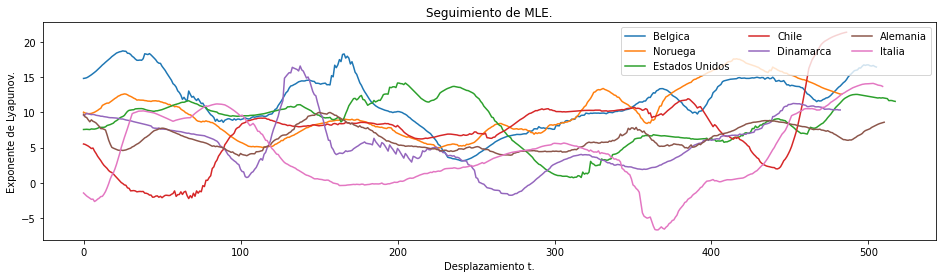

In [19]:
plt.figure(figsize=(16,4))
for k in range(7):
    plt.plot(Lyapse[k][:600])
plt.xlabel('Desplazamiento t.')
plt.ylabel('Exponente de Lyapunov.')
plt.title('Seguimiento de MLE.')
plt.legend(Paises,loc='upper right',ncol=3)
plt.show()

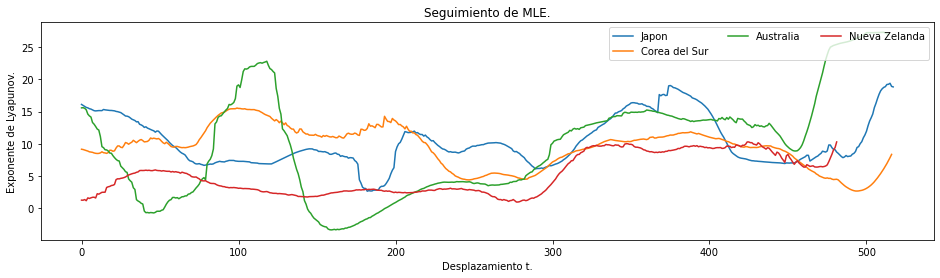

In [20]:
plt.figure(figsize=(16,4))
for k in range(7,N):
    plt.plot(Lyapse[k][:600])
plt.xlabel('Desplazamiento t.')
plt.ylabel('Exponente de Lyapunov.')
plt.title('Seguimiento de MLE.')
plt.legend(Paises[7:],loc='upper right',ncol=3)
plt.show()

In [21]:
Paises=['Belgica', 'Noruega', 'Estados Unidos', 'Chile', 'Dinamarca', 'Alemania', 'Italia', 'Japon', 'Corea del Sur',
       'Australia','Nueva Zelanda']

In [22]:
FechasBelgica=Blegiumdata['date'].astype(str).values.tolist()
FechasNoruega=Norwaydata['date'].astype(str).values.tolist()[1:]
FechasUS=USdata['date'].astype(str).values.tolist()[1:]
FechasChile=Chiledata['date'].astype(str).values.tolist()
FechasDinamarca=Denmarkdata['date'].astype(str).values.tolist()[25:]
FechasCanada=Canadadata['date'].astype(str).values.tolist()
FechasCzechR=CzechRdata['date'].astype(str).values.tolist()
FechasNZ=NZdata['date'].astype(str).values.tolist()
FechasAlemania=Alemaniadata['date'].astype(str).values.tolist()[3:]
FechasItaliats=Italydata['date'].astype(str).values.tolist()
FechasJapan=Japandata['date'].astype(str).values.tolist()[1:]
FechasSK=SKdata['date'].astype(str).values.tolist()[2:]
FechasAustralia=Australiadata['date'].astype(str).values.tolist()

In [23]:
FechasAustralia

['2020-01-26',
 '2020-01-27',
 '2020-01-28',
 '2020-01-29',
 '2020-01-30',
 '2020-01-31',
 '2020-02-01',
 '2020-02-02',
 '2020-02-03',
 '2020-02-04',
 '2020-02-05',
 '2020-02-06',
 '2020-02-07',
 '2020-02-08',
 '2020-02-09',
 '2020-02-10',
 '2020-02-11',
 '2020-02-12',
 '2020-02-13',
 '2020-02-14',
 '2020-02-15',
 '2020-02-16',
 '2020-02-17',
 '2020-02-18',
 '2020-02-19',
 '2020-02-20',
 '2020-02-21',
 '2020-02-22',
 '2020-02-23',
 '2020-02-24',
 '2020-02-25',
 '2020-02-26',
 '2020-02-27',
 '2020-02-28',
 '2020-02-29',
 '2020-03-01',
 '2020-03-02',
 '2020-03-03',
 '2020-03-04',
 '2020-03-05',
 '2020-03-06',
 '2020-03-07',
 '2020-03-08',
 '2020-03-09',
 '2020-03-10',
 '2020-03-11',
 '2020-03-12',
 '2020-03-13',
 '2020-03-14',
 '2020-03-15',
 '2020-03-16',
 '2020-03-17',
 '2020-03-18',
 '2020-03-19',
 '2020-03-20',
 '2020-03-21',
 '2020-03-22',
 '2020-03-23',
 '2020-03-24',
 '2020-03-25',
 '2020-03-26',
 '2020-03-27',
 '2020-03-28',
 '2020-03-29',
 '2020-03-30',
 '2020-03-31',
 '2020-04-

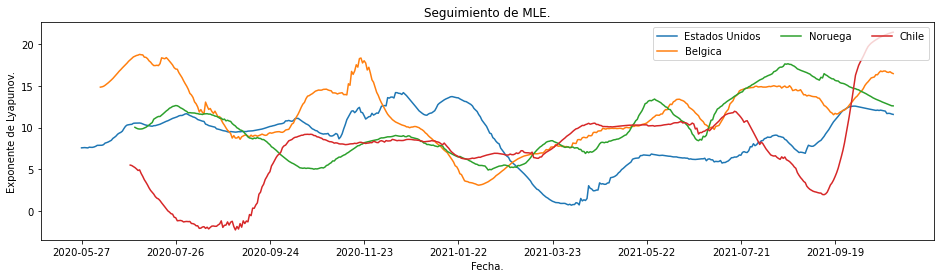

In [24]:
plt.figure(figsize=(16,4))
plt.plot(FechasUS[125:125+len(Lyapse[2])],Lyapse[2])
plt.plot(FechasBelgica[125:125+len(Lyapse[0])],Lyapse[0])
plt.plot(FechasNoruega[125:125+len(Lyapse[1])],Lyapse[1])
plt.plot(FechasChile[125:125+len(Lyapse[3])],Lyapse[3])
plt.xlabel('Fecha.')
plt.ylabel('Exponente de Lyapunov.')
plt.title('Seguimiento de MLE.')
plt.legend(['Estados Unidos','Belgica', 'Noruega',  'Chile'],loc='upper right',ncol=3)
plt.xticks([0,60,120,180,240,300,360,420,480])
plt.show()

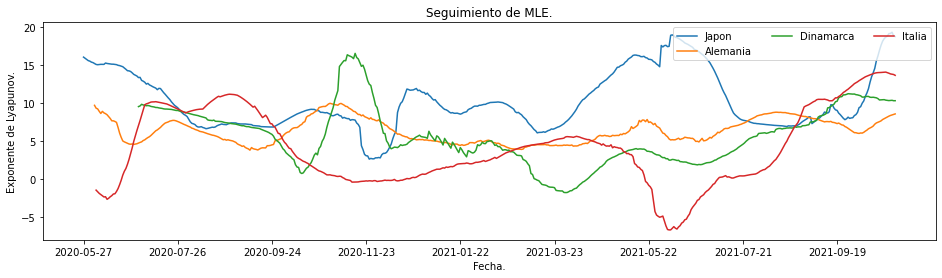

In [25]:
plt.figure(figsize=(16,4))
plt.plot(FechasJapan[125:125+len(Lyapse[7])],Lyapse[7])
plt.plot(FechasAlemania[125:125+len(Lyapse[5])],Lyapse[5])
plt.plot(FechasDinamarca[125:125+len(Lyapse[4])],Lyapse[4])
plt.plot(FechasItaliats[125:125+len(Lyapse[6])],Lyapse[6])

plt.xlabel('Fecha.')
plt.ylabel('Exponente de Lyapunov.')
plt.title('Seguimiento de MLE.')
plt.legend(['Japon','Alemania','Dinamarca','Italia'],loc='upper right',ncol=3)
plt.xticks([0,60,120,180,240,300,360,420,480])
plt.show()

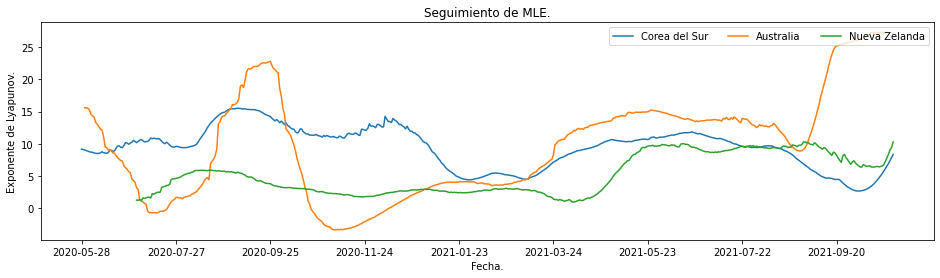

In [26]:
plt.figure(figsize=(16,4))
plt.plot(FechasSK[125:125+len(Lyapse[8])],Lyapse[8])
plt.plot(FechasAustralia[125:125+len(Lyapse[9])],Lyapse[9])
plt.plot(FechasNZ[125:125+len(Lyapse[10])],Lyapse[10])
plt.xticks([0,60,120,180,240,300,360,420,480])
plt.xlabel('Fecha.')
plt.ylabel('Exponente de Lyapunov.')
plt.title('Seguimiento de MLE.')
plt.legend(['Corea del Sur', 'Australia','Nueva Zelanda'],loc='upper right',ncol=3)
plt.show()

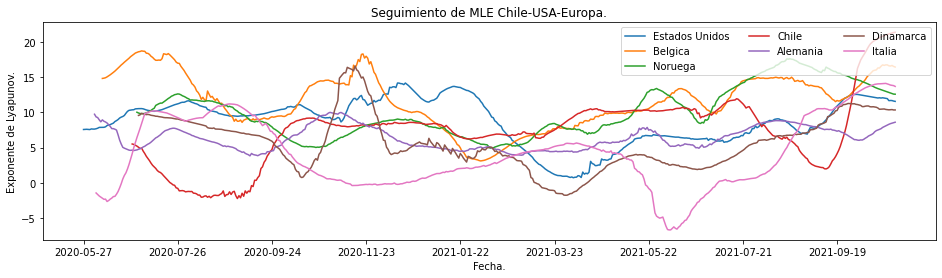

In [27]:
plt.figure(figsize=(16,4))
plt.plot(FechasUS[125:125+len(Lyapse[2])],Lyapse[2])
plt.plot(FechasBelgica[125:125+len(Lyapse[0])],Lyapse[0])
plt.plot(FechasNoruega[125:125+len(Lyapse[1])],Lyapse[1])
plt.plot(FechasChile[125:125+len(Lyapse[3])],Lyapse[3])
plt.plot(FechasAlemania[125:125+len(Lyapse[5])],Lyapse[5])
plt.plot(FechasDinamarca[125:125+len(Lyapse[4])],Lyapse[4])
plt.plot(FechasItaliats[125:125+len(Lyapse[6])],Lyapse[6])

plt.xlabel('Fecha.')
plt.ylabel('Exponente de Lyapunov.')
plt.title('Seguimiento de MLE Chile-USA-Europa.')
plt.legend(['Estados Unidos','Belgica', 'Noruega',  'Chile','Alemania', 'Dinamarca', 'Italia'],loc='upper right',ncol=3)
plt.xticks([0,60,120,180,240,300,360,420,480])
plt.show()

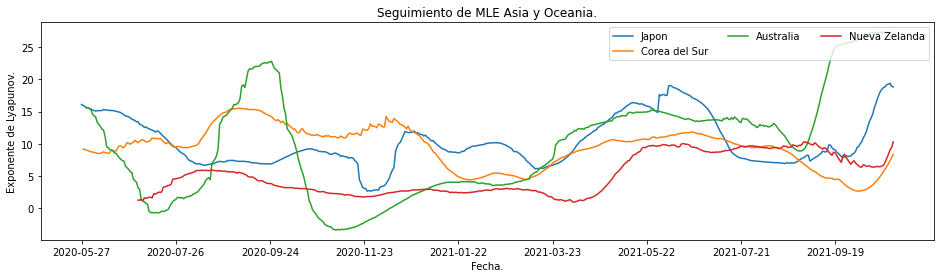

In [28]:
plt.figure(figsize=(16,4))
plt.plot(FechasJapan[125:125+len(Lyapse[7])],Lyapse[7])
plt.plot(FechasSK[125:125+len(Lyapse[8])],Lyapse[8])
plt.plot(FechasAustralia[125:125+len(Lyapse[9])],Lyapse[9])
plt.plot(FechasNZ[125:125+len(Lyapse[10])],Lyapse[10])
plt.xticks([0,60,120,180,240,300,360,420,480])
plt.xlabel('Fecha.')
plt.ylabel('Exponente de Lyapunov.')
plt.title('Seguimiento de MLE Asia y Oceania.')
plt.legend(['Japon','Corea del Sur', 'Australia','Nueva Zelanda'],loc='upper right',ncol=3)
plt.show()

In [30]:
import numpy as np
Paises=['Belgica', 'Noruega', 'Estados Unidos', 'Chile', 'Dinamarca', 'Alemania', 'Italia', 'Japon', 'Corea del Sur',
       'Australia','Nueva Zelanda']
for j in range(len(Paises)):
    a = np.asarray([ Lyapse[j]])
    np.savetxt( Paises[j]+'.csv', a, delimiter=",")